In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from src.domain import Domain
from src.interpolation import SplineInter
from src.transformations import Affine2d
from src.plotting import view_image_2d, plot_grid_2d
from src.super_resolution_tools import *
from src.transformations import Affine2d
from src.LinearOperator import LinearOperator
from src.lanczos import lanczos_tridiag
# from src.conjugate_gradient import conjugate_gradient
from src.utils import * 
from src.optimization import *
import torch.func as func
from src.distance import SSDDistance
import time

torch.set_default_dtype(torch.float64)

In [2]:
def show_reference_and_templates(R, T):

    # Determine the layout for the subplots
    num_images = 1 + T.shape[0]  # Total number of images (reference + targets)
    cols = int(torch.ceil(torch.sqrt(torch.tensor(num_images).float())))  # Number of columns (and rows in a square layout)
    rows = int(torch.ceil(torch.tensor(num_images).float() / cols))  # Number of rows needed to accommodate all images

    # Create the figure with subplots
    _, ax = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

    # Flatten the ax array for easier indexing
    ax = ax.flatten()

    # Display the reference image
    ax[0].imshow(R.detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
    ax[0].set_title('Reference')
    ax[0].axis('off')  # Optional: hide axes for cleaner visualization

    # Display the target images
    for k in range(T.shape[0]):
        ax[k + 1].imshow(T[k].detach().T.flip(dims=(0,)), cmap='gray')  # Convert tensor to NumPy array for imshow
        ax[k + 1].set_title(f'T_{k}')
        ax[k + 1].axis('off')  # Optional: hide axes for cleaner visualization

    # Turn off any unused subplots
    for i in range(1 + T.shape[0], len(ax)):
        ax[i].axis('off')

    plt.tight_layout()  # Adjust subplots to fit into the figure area nicely
    plt.show()

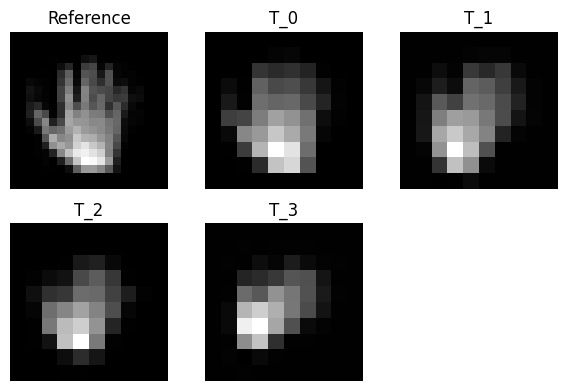

In [3]:
m = 20
factor = 2
theta = 0
n_images = 4

domain_R = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m, m)))
domain_R.m.detach()
domain_T = Domain(torch.tensor((0, 20, 0, 25)), torch.tensor((m//factor, m//factor)))
xc = domain_R.getCellCenteredGrid().view(-1, 2).to(torch.float64)
times = torch.linspace(0, 15, n_images)

R = Image.open('../data/hands-R.jpg')
R = R.resize((m, m))
R = torch.fliplr(torch.tensor(R.getdata(), dtype=torch.float64).view(m,m).transpose(0,1))
Rimg = SplineInter(R, domain_R ,regularizer='moments',theta=theta).to(torch.float64)

def randomAffines(reference, n):
    affines = [getRandomAffine(rotation_range=(0,45),seed=_+2) for _ in range(n-1)]
    templates = [down_sample(reference(xc).reshape(m, m), factor)]
    for aff in affines:
        affine = Affine2d()
        affine.A = torch.nn.Parameter(aff[0].to(torch.float64))
        affine.b = torch.nn.Parameter(aff[1].to(torch.float64))
        templates.append(down_sample(reference(affine(xc)).reshape(m, m), factor))
    return torch.stack(templates)

T = randomAffines(Rimg, len(times))

show_reference_and_templates(R, T)

In [4]:
def L_forward(f):
    reference = f.reshape(*domain_R.m)
    diff_0 = torch.diff(reference, dim = 0) / domain_R.h[0]
    diff_1 = torch.diff(reference, dim = 1) / domain_R.h[1]
    return torch.hstack([diff_0.flatten(), diff_1.flatten()])

L = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun=L_forward, dtype = torch.float64)

def K_forward(f):
    reference = f.reshape(*domain_R.m)
    downsampled = down_sample(reference, factor).flatten()
    return downsampled.flatten() 

K = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun=K_forward, dtype = torch.float64)
# f0_interp = K.T @ T[0].flatten().detach()
Timg = SplineInter(T[0].detach(),domain_T, regularizer='moments', theta=1e-2)
f0_interp = Timg(domain_R.getCellCenteredGrid()).flatten()

d = T.flatten()
b = torch.hstack([d * torch.sqrt(torch.prod(domain_T.h)), torch.zeros_like(L @ f0_interp)])

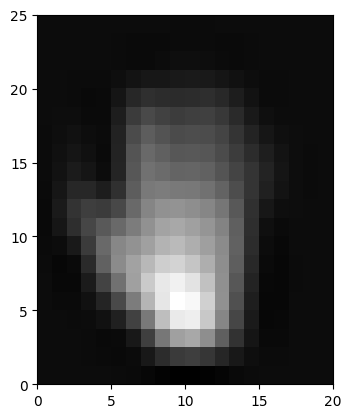

In [5]:
view_image_2d(f0_interp, domain_R)

In [6]:
xc_2d = domain_R.getCellCenteredGrid()
xc = xc_2d.reshape(torch.prod(domain_R.m).item(),2).detach()

ys = [Affine2d() for _ in range(n_images)]
for y in ys:
    for param in y.parameters():
        param.to(torch.float64)
        param.requires_grad_(True)

lam = 1e-2

wps = [{k: v for k, v in y.named_parameters()} for y in ys]
keys_list = [wp.keys() for wp in wps]

flat_params_list, shapes_list, sizes_list = flatten_params_list(wps)
wp_vec0 = torch.stack(flat_params_list).flatten().unsqueeze(1)


In [7]:
f0_grad = None
f0_nograd = None
def conjugate_gradient(A, b, x0, max_iter=500, tol=1e-3):
    x = x0.clone()
    r = b - A(x)
    p = r.clone()
    rsold = r.dot(r)
        
    for i in range(max_iter):
        Ap = A(p)
        alpha = rsold / p.dot(Ap)
        x = x + alpha * p  
        r = r - alpha * Ap  
        rsnew = r.dot(r)
        if torch.sqrt(rsnew) < tol:
            # print(f"tol reached {i}")
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    # print(f"residual norm: {torch.sqrt(rsnew)}")
    return x
    

def conjugate_gradient_nograd(A, b, x0, max_iter=500, tol=1e-3):
    with torch.no_grad():
        x = x0.clone()
        r = b - A(x)
        p = r.clone()
        rsold = r.dot(r)
        for i in range(max_iter):
            Ap = A(p)
            alpha = rsold / p.dot(Ap)
            x = x + alpha * p 
            x = x.detach()
            r = r - alpha * Ap  
            rsnew = r.dot(r)
            if torch.sqrt(rsnew) < tol:
                break
            p = r + (rsnew / rsold) * p
            rsold = rsnew
        # print(f"residual norm: {torch.sqrt(rsnew)}")
        return x

def Forward_single(wp, y, f_inter):
    w_dict = unflatten_params(wp, keys_list[0], shapes_list[0], sizes_list[0])
    yc = func.functional_call(y, w_dict, xc)
    d_pred = K(f_inter(yc))
    return d_pred

def res_fn(wp_vec, cg_iter):
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R).to(torch.float64)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

        regularizer = lam * L(f)
        
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)

    f0 = conjugate_gradient(A.T ^ A, A.T @ b, f0_interp, max_iter=cg_iter)
    reference = f0.reshape(*domain_R.m)    
    reference_img = SplineInter(reference, domain_R).to(torch.float64)
    template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

    return template_predictions - d

def res_fn_nodiff(wp_vec, cg_iter):
    def A_forward(f):
        reference = f.reshape(*domain_R.m)        
        reference_img = SplineInter(reference, domain_R)
        template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

        regularizer = lam * L(f)
        
        return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                                regularizer * torch.sqrt(torch.prod(domain_R.h))])
    
    A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)

    f0 = conjugate_gradient_nograd(A.T ^ A, A.T @ b, f0_interp, max_iter= cg_iter)
    reference = f0.reshape(*domain_R.m)        
    reference_img = SplineInter(reference, domain_R)
    template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])

    return template_predictions - d

def Jac_fn(wp_vec, cg_iter):
    return func.jacfwd(res_fn)(wp_vec, cg_iter).detach().squeeze()

def Jac_fn_nodiff(wp_vec, cg_iter):
    return func.jacfwd(res_fn_nodiff)(wp_vec, cg_iter).detach().squeeze()



/tmp/ipykernel_5659/1132697583.py:63: OptimizeWarning: Unknown solver options: gtol
  results = minimize(scipy_loss, x0=tensor_to_numpy(wp_vec0).flatten(), method='newton-cg',


1 - Current Loss: 1.0555376382e+03, Norm of Gradient: 5.7229757639e+00
2 - Current Loss: 1.0547046990e+03, Norm of Gradient: 2.5157404155e+00
3 - Current Loss: 1.0488961794e+03, Norm of Gradient: 2.4696706306e+00
4 - Current Loss: 1.0488679107e+03, Norm of Gradient: 9.2816671284e-01
5 - Current Loss: 1.0488148898e+03, Norm of Gradient: 7.8898467079e-01
6 - Current Loss: 1.0483623276e+03, Norm of Gradient: 5.4576077156e-01
7 - Current Loss: 1.0478852110e+03, Norm of Gradient: 6.4661648629e-01
8 - Current Loss: 1.0478501375e+03, Norm of Gradient: 2.8450896779e-01
9 - Current Loss: 1.0478365905e+03, Norm of Gradient: 2.8032253190e-01
10 - Current Loss: 1.0478219502e+03, Norm of Gradient: 9.1878506983e-02
11 - Current Loss: 1.0477993025e+03, Norm of Gradient: 5.8426544828e-02
12 - Current Loss: 1.0477806385e+03, Norm of Gradient: 1.1613294956e-01
13 - Current Loss: 1.0477797381e+03, Norm of Gradient: 2.6692502874e-02
14 - Current Loss: 1.0477718769e+03, Norm of Gradient: 3.0323688206e-02
1

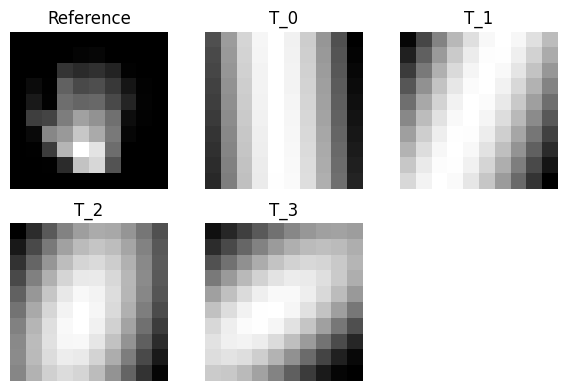

1 - Current Loss: 6.8930616525e+02, Norm of Gradient: 7.1407811310e+01
2 - Current Loss: 6.7186849656e+02, Norm of Gradient: 2.4631488032e+01
3 - Current Loss: 6.6872222029e+02, Norm of Gradient: 6.8075814053e+00
4 - Current Loss: 6.6464596606e+02, Norm of Gradient: 5.5571363296e+00
5 - Current Loss: 6.6456220004e+02, Norm of Gradient: 2.4104980256e+00
6 - Current Loss: 6.6442145393e+02, Norm of Gradient: 1.6114060175e+00
7 - Current Loss: 6.6430349500e+02, Norm of Gradient: 8.0723685487e-01
8 - Current Loss: 6.6428878677e+02, Norm of Gradient: 3.1527902922e-01
9 - Current Loss: 6.6400300756e+02, Norm of Gradient: 4.7747513596e+00
10 - Current Loss: 6.6392719597e+02, Norm of Gradient: 1.7784998324e+00
11 - Current Loss: 6.6388516307e+02, Norm of Gradient: 4.4044627334e-01
12 - Current Loss: 6.6354863525e+02, Norm of Gradient: 4.4190212226e+00
13 - Current Loss: 6.6350691261e+02, Norm of Gradient: 5.1797431977e-01
14 - Current Loss: 6.6343990493e+02, Norm of Gradient: 3.2030173555e-01
1

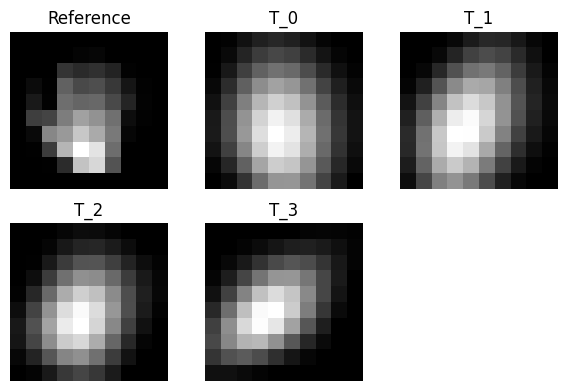

/tmp/ipykernel_5659/1132697583.py:63: OptimizeWarning: Unknown solver options: gtol
  results = minimize(scipy_loss, x0=tensor_to_numpy(wp_vec0).flatten(), method='newton-cg',


1 - Current Loss: 4.9379983606e+02, Norm of Gradient: 3.6928773396e+02
2 - Current Loss: 4.2194272883e+02, Norm of Gradient: 2.3912195504e+02
3 - Current Loss: 4.1295978259e+02, Norm of Gradient: 1.0432984615e+02
4 - Current Loss: 4.0276811589e+02, Norm of Gradient: 3.6387538145e+01
5 - Current Loss: 3.9834266632e+02, Norm of Gradient: 2.0639900641e+01
6 - Current Loss: 3.9139265459e+02, Norm of Gradient: 1.3475331560e+01
7 - Current Loss: 3.8844166669e+02, Norm of Gradient: 8.7770230452e+00
8 - Current Loss: 3.8834960182e+02, Norm of Gradient: 3.3146664924e+00
9 - Current Loss: 3.8509454875e+02, Norm of Gradient: 1.4735998235e+01
10 - Current Loss: 3.8485979153e+02, Norm of Gradient: 3.3975526348e+00
11 - Current Loss: 3.8286720748e+02, Norm of Gradient: 6.8283908576e+00
12 - Current Loss: 3.8280127075e+02, Norm of Gradient: 2.1607771229e+00
13 - Current Loss: 3.8222764863e+02, Norm of Gradient: 5.0588690192e+00
14 - Current Loss: 3.8218102484e+02, Norm of Gradient: 1.9852543020e+00
1

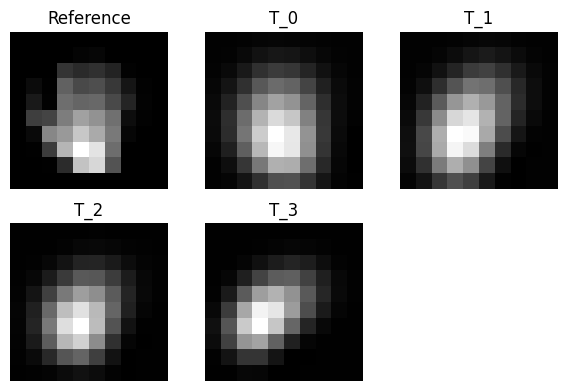

/tmp/ipykernel_5659/1132697583.py:63: OptimizeWarning: Unknown solver options: gtol
  results = minimize(scipy_loss, x0=tensor_to_numpy(wp_vec0).flatten(), method='newton-cg',


1 - Current Loss: 4.3532960553e+02, Norm of Gradient: 8.2005462348e+02
2 - Current Loss: 3.4952899608e+02, Norm of Gradient: 3.8091499635e+02
3 - Current Loss: 3.2568512175e+02, Norm of Gradient: 2.9804014595e+02
4 - Current Loss: 3.1294773508e+02, Norm of Gradient: 9.2382713213e+01
5 - Current Loss: 2.9663725019e+02, Norm of Gradient: 7.1099328656e+01
6 - Current Loss: 2.7230323167e+02, Norm of Gradient: 1.3225223671e+02
7 - Current Loss: 2.7139984716e+02, Norm of Gradient: 3.6554173558e+01
8 - Current Loss: 2.7024993101e+02, Norm of Gradient: 1.3161174179e+01
9 - Current Loss: 2.5987247641e+02, Norm of Gradient: 1.1668537156e+01
10 - Current Loss: 2.4365533681e+02, Norm of Gradient: 2.1190994213e+01
11 - Current Loss: 2.4076733604e+02, Norm of Gradient: 1.0051959938e+01
12 - Current Loss: 2.3883120203e+02, Norm of Gradient: 5.4802568761e+00
13 - Current Loss: 2.2444925501e+02, Norm of Gradient: 1.1301918655e+02
14 - Current Loss: 2.1964701857e+02, Norm of Gradient: 6.2083391654e+01
1

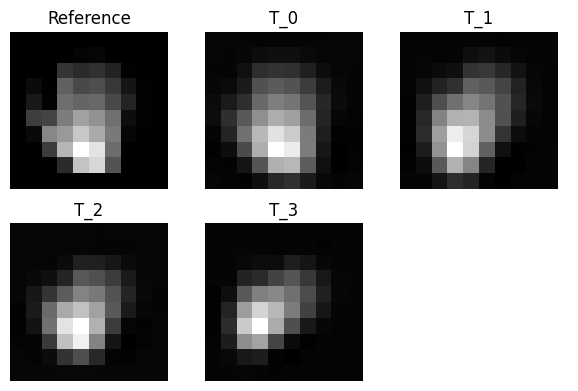

1 - Current Loss: 4.8817510137e+02, Norm of Gradient: 8.2200771725e+02
2 - Current Loss: 3.9775355408e+02, Norm of Gradient: 8.6285140694e+02
3 - Current Loss: 3.5583355013e+02, Norm of Gradient: 5.1194983008e+02
4 - Current Loss: 3.1054727568e+02, Norm of Gradient: 2.9860123759e+02
5 - Current Loss: 3.0368083341e+02, Norm of Gradient: 1.7749091988e+02
6 - Current Loss: 2.9260919679e+02, Norm of Gradient: 1.1220990528e+02
7 - Current Loss: 2.8698137124e+02, Norm of Gradient: 5.2814120378e+01
8 - Current Loss: 2.7669008703e+02, Norm of Gradient: 5.1122835566e+01
9 - Current Loss: 2.6103195464e+02, Norm of Gradient: 7.3787593928e+01
10 - Current Loss: 2.5946743018e+02, Norm of Gradient: 1.3904176623e+02
11 - Current Loss: 2.5757027566e+02, Norm of Gradient: 1.2748732097e+02
12 - Current Loss: 2.5484966322e+02, Norm of Gradient: 1.8463385308e+02
13 - Current Loss: 2.4963922119e+02, Norm of Gradient: 1.9168891666e+02
14 - Current Loss: 2.4140872386e+02, Norm of Gradient: 1.4610624828e+02
1

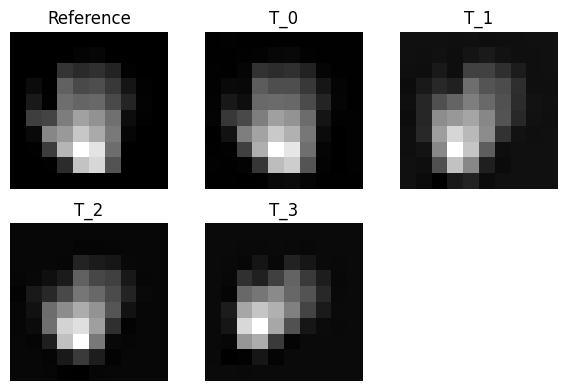

1 - Current Loss: 5.3974950365e+02, Norm of Gradient: 9.1917532062e+02
2 - Current Loss: 4.0795296290e+02, Norm of Gradient: 5.1153505939e+02
3 - Current Loss: 3.6909991169e+02, Norm of Gradient: 4.6788984580e+02
4 - Current Loss: 3.2191888733e+02, Norm of Gradient: 2.0457207161e+02
5 - Current Loss: 2.9808639081e+02, Norm of Gradient: 2.2497796216e+02
6 - Current Loss: 2.9443105862e+02, Norm of Gradient: 7.1533652885e+01
7 - Current Loss: 2.8926815699e+02, Norm of Gradient: 2.9748675359e+01
8 - Current Loss: 2.8025159820e+02, Norm of Gradient: 3.2001027708e+01
9 - Current Loss: 2.6868988824e+02, Norm of Gradient: 5.5571379638e+01
10 - Current Loss: 2.6826108362e+02, Norm of Gradient: 1.9220244814e+01
11 - Current Loss: 2.4069657883e+02, Norm of Gradient: 1.4440475433e+02
12 - Current Loss: 2.3796967260e+02, Norm of Gradient: 2.3122029843e+01
13 - Current Loss: 2.1460083116e+02, Norm of Gradient: 7.5294622142e+01
14 - Current Loss: 2.1422087397e+02, Norm of Gradient: 3.3948818283e+01
1

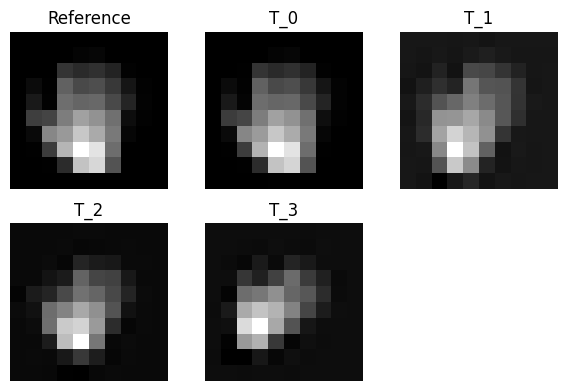

In [8]:
# preregistration

# pre-reg

from scipy.optimize import minimize

def single_img_trafo(wp,y):
    w_dict = unflatten_params(wp, keys_list[0], shapes_list[0], sizes_list[0])
    yc = func.functional_call(y, w_dict, domain_T.getCellCenteredGrid())
    # print(Timg(yc).shape)
    return Timg(yc).flatten()

def lossfn(wp_vec):
    pred_d = torch.hstack([single_img_trafo(wp_vec.reshape(-1,6)[j], ys[j]) for j in range(n_images)])
    return torch.norm(pred_d - d)


def scipy_loss(wc):
    global last_loss
    wc_tensor = numpy_to_tensor(wc)
    loss = lossfn(wc_tensor)
    last_loss = loss.item()
    return last_loss

def scipy_grad(wc):
    global last_grad
    wc = numpy_to_tensor(wc)
    grad = torch.func.grad(lossfn, argnums=0)(wc).detach()
    last_grad = tensor_to_numpy(grad)
    return last_grad

def scipy_hessian(wc):
    wc = numpy_to_tensor(wc)
    hessian = torch.func.hessian(lossfn, argnums=0)(wc).detach()
    hessian = .5 * (hessian + hessian.T)
    return tensor_to_numpy(hessian)

def callback(xk):
    norm_grad = np.linalg.norm(last_grad)
    grad_norms.append(norm_grad)
    global iteration_num
    iteration_num+=1
    print(f'{iteration_num} - Current Loss: {last_loss:.10e}, Norm of Gradient: {norm_grad:.10e}')

# multi-scale 

thetas = torch.logspace(2, -3, 6)

for theta in thetas:

    theta_np = tensor_to_numpy(theta)

    last_loss = None
    last_grad = None
    iteration_num = 0

    grad_norms = []

    Timg = SplineInter(T[0].detach(), domain_T,regularizer='moments',theta=theta)
    Rimgs = [SplineInter(T[i], domain_T, regularizer='moments', theta=theta) for i in range(n_images)]
    Rcs = torch.stack([Rimgs[i](domain_T.getCellCenteredGrid()) for i in range(len(Rimgs))])

    results = minimize(scipy_loss, x0=tensor_to_numpy(wp_vec0).flatten(), method='newton-cg',
               jac=scipy_grad, hess=scipy_hessian,
               options={'gtol': 1e-2, 'maxiter':50}, callback=callback)
    
    template_predictions = torch.stack([single_img_trafo(numpy_to_tensor(results.x).reshape(-1,6)[j], ys[j]).reshape(*domain_T.m) for j in range(n_images)])
    show_reference_and_templates(T[0], template_predictions)


In [9]:
maxcg_iters = 500 # verified that all iterations stop before reaching max_iters
max_iter = 10

f0_grads = []
loss_grads = []
grad_grads = []

#with grad
wp_list,_,losses,grads = lsq_lma(numpy_to_tensor(results.x).flatten(), 
                                    res_fn, 
                                    Jac_fn, 
                                    args=[maxcg_iters], 
                                    gtol=1e-5, 
                                    max_iter=max_iter, 
                                    verbose=True, 
                                    return_loss_and_grad=True)
wp_vec = wp_list[-1]
def A_forward(f):
    reference = f.reshape(*domain_R.m)        
    reference_img = SplineInter(reference, domain_R)
    template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])
    regularizer = lam * L(f)
    return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                            regularizer * torch.sqrt(torch.prod(domain_R.h))])
A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)
f0 = conjugate_gradient_nograd(A.T ^ A, A.T @ b, f0_interp, max_iter= 5000, tol=1e-12)
f0_grad_reshaped = f0.reshape(*domain_R.m)

f0_grads.append(f0_grad_reshaped.clone().detach())
loss_grads.append(losses)
grad_grads.append(grads)

#without grad
wp_list,_,losses,grads = lsq_lma(numpy_to_tensor(results.x).flatten(), 
                                    res_fn_nodiff, 
                                    Jac_fn_nodiff, 
                                    args=[maxcg_iters], 
                                    gtol=1e-5, 
                                    max_iter=max_iter, 
                                    verbose=True, 
                                    return_loss_and_grad=True)
wp_vec = wp_list[-1]
def A_forward(f):
    reference = f.reshape(*domain_R.m)        
    reference_img = SplineInter(reference, domain_R)
    template_predictions = torch.hstack([Forward_single(wp_vec.reshape(-1,6)[j], ys[j], reference_img)[0] for j in range(n_images)])
    regularizer = lam * L(f)
    return torch.hstack([template_predictions * torch.sqrt(torch.prod(domain_T.h)),
                            regularizer * torch.sqrt(torch.prod(domain_R.h))])
A = LinearOperator((torch.prod(domain_R.m).item(),), forward_fun = A_forward, dtype = torch.float64)
f0 = conjugate_gradient_nograd(A.T ^ A, A.T @ b, f0_interp, max_iter= 5000, tol=1e-12)
f0_grad_reshaped = f0.reshape(*domain_R.m)

f0_grads.append(f0_grad_reshaped.clone().detach())
loss_grads.append(losses)
grad_grads.append(grads)

Loss: 3.1410e+00 Grad: 5.8142e+02
Loss: 6.9426e-01 Grad: 5.2818e+01
Loss: 4.3870e-01 Grad: 1.0297e+01
Loss: 2.9379e-01 Grad: 1.0378e+01
Loss: 2.1883e-01 Grad: 1.6501e+00
Loss: 1.8505e-01 Grad: 2.1604e+00
Loss: 1.6783e-01 Grad: 1.6758e+00
Loss: 1.6350e-01 Grad: 1.4474e+00
Loss: 1.6350e-01 Grad: 1.4474e+00
Loss: 1.6350e-01 Grad: 1.4474e+00
Loss: 3.1410e+00 Grad: 1.3861e+03
Loss: 2.8485e+00 Grad: 1.2512e+03
Loss: 2.5925e+00 Grad: 1.1313e+03
Loss: 2.3706e+00 Grad: 1.0259e+03
Loss: 2.1798e+00 Grad: 9.3336e+02
Loss: 2.0169e+00 Grad: 8.5247e+02
Loss: 1.8784e+00 Grad: 7.8188e+02
Loss: 1.7611e+00 Grad: 7.2005e+02
Loss: 1.6618e+00 Grad: 6.6607e+02
Loss: 1.5775e+00 Grad: 6.1852e+02


<function matplotlib.pyplot.show(close=None, block=None)>

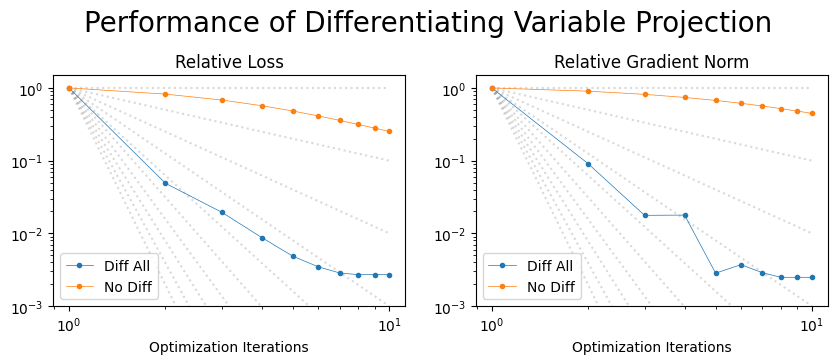

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

states = ["Diff All", "No Diff"]

plt.sca(ax[0])
for i in range(max_iter):
    plt.loglog(np.arange(max_iter) + 1, 1/(np.arange(max_iter) + 1)**(i), color='gray', alpha=.3, linestyle=':')
for i in range(len(states)):
    plt.loglog(np.arange(max_iter) + 1, np.array(loss_grads[i])/loss_grads[i][0], label="{}".format(states[i]), linewidth=0.5, marker = '.')
plt.legend()
plt.ylim(10e-4,1.5)
plt.title('Relative Loss')
plt.xlabel('Optimization Iterations')

plt.sca(ax[1])
for i in range(max_iter):
    plt.loglog(np.arange(max_iter) + 1, 1/(np.arange(max_iter) + 1)**(i), color='gray', alpha=.3, linestyle=':')
for i in range(len(states)):
    plt.loglog(np.arange(max_iter) + 1, np.array(grad_grads[i])/grad_grads[i][0], label="{}".format(states[i]), linewidth=0.5, marker = '.')
plt.legend()
plt.ylim(10e-4,1.5)
plt.title('Relative Gradient Norm')
plt.xlabel('Optimization Iterations')

# plt.sca(ax[2])
# plt.bar(["Diff All", "No Diff"], np.array([torch.norm(f - R) for f in f0_grads])/torch.norm(R), color = ["C0", "C1"])
# plt.title('Final Relative Error')

plt.suptitle('Performance of Differentiating Variable Projection', y = 1.1, size=20)
plt.savefig('../results/figs/diff_CG_og_performance.pdf', bbox_inches='tight')
plt.show

In [21]:
np.array([torch.norm(f - R) for f in f0_grads])/torch.norm(R)

tensor([0.1070, 0.2561])

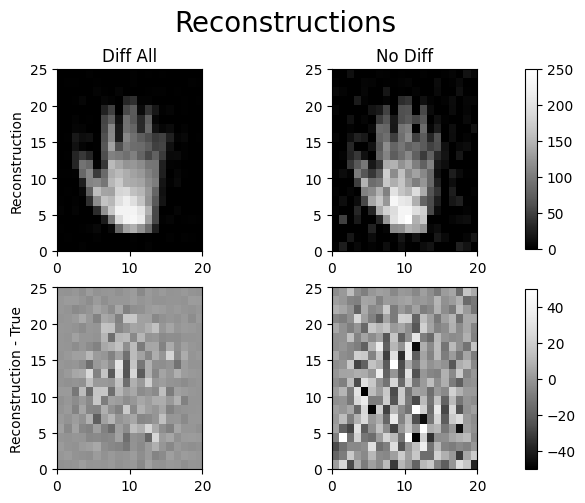

In [22]:
fig, ax = plt.subplots(2, len(states), figsize=(6,4))

for i in range(len(states)):
    #ax[0,i].axis('off')
    #ax[1,i].axis('off')

    plt.sca(ax[0,i])
    im_0 = view_image_2d(f0_grads[i],domain_R, kwargs={'clim':(0,250), 'cmap':'Greys_r'})
    plt.title("{}".format(states[i]))

    plt.sca(ax[1,i])
    im_1 = view_image_2d(f0_grads[i] - R,domain_R, kwargs={'clim':(-50,50), 'cmap':'Greys_r'})

ax[0,0].set_ylabel("Reconstruction")
ax[1,0].set_ylabel("Reconstruction - True")

fig.subplots_adjust(0,0,.84,1)

# Create colorbar axes
cbar_ax1 = fig.add_axes([0.85, 0.55, 0.02, 0.45])  # x, y, width, height
cbar_ax2 = fig.add_axes([0.85, 0.0, 0.02, 0.45])

# Create colorbars in the new axes
cbar1 = plt.colorbar(im_0, cax=cbar_ax1)
cbar2 = plt.colorbar(im_1, cax=cbar_ax2)

plt.suptitle('Reconstructions', y = 1.15, x=.45, size=20)

plt.savefig('../results/figs/og_diffreconstructions.pdf', bbox_inches='tight')

plt.show()


# Computational Complexity of this problem

In [13]:
# import timeit

# %timeit -n 1 -r 1000 res_fn_nodiff(numpy_to_tensor(results.x), 50)

In [14]:
# %timeit -n 1 -r 1000 Jac_fn_nodiff(numpy_to_tensor(results.x), 50)

In [15]:
# %timeit -n 1 -r 1000 res_fn(numpy_to_tensor(results.x), 50)

In [16]:
# %timeit -n 1 -r 1000 Jac_fn(numpy_to_tensor(results.x), 50)